# Import Dependencies

In [82]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
import re
import tensorflow as tf
import matplotlib.pyplot as plt

from PIL import Image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from nltk.translate.bleu_score import corpus_bleu

In [2]:
Base_dir = '/kaggle/input/flickr8k'
Working_dir = '/kaggle/working'

# Extract image features

In [4]:
#load vgg16 model
model = VGG16()

#restructure the model
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)
model.summary()


553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# extract feature from images
features = {}
directory = os.path.join(Base_dir, 'Images')

for img_name in tqdm(os.listdir(directory)): # loop over the directory and returns the list of all files and folder in the directory
    #load image from file
    img_path = os.path.join(directory, img_name)
    image = load_img(img_path, target_size = (224,224), color_mode = 'rgb')
    #convert img pixels to numpy array i.e PIL to nparray
    image = img_to_array(image)
    #reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    #preprocessing image for vgg
    image = preprocess_input(image)
    #extract features
    feature = model.predict(image, verbose = 0)
    #get image id
    image_id = img_name.split('.')[0]
    #store features
    features[image_id] = feature


  0%|          | 0/8091 [00:00<?, ?it/s]

In [6]:
print(f"Total features extracted: {len(features)}")
first_feature = list(features.values())[0]  
print("Sample image feature vector:", first_feature)
print("Shape of feature vector:", first_feature.shape)

Total features extracted: 8091
Sample image feature vector: [[0.        1.6273934 0.        ... 0.        1.5637898 0.       ]]
Shape of feature vector: (1, 4096)


In [7]:
# store features in pickle
pickle.dump(features, open(os.path.join(Working_dir, 'features.pkl'), 'wb'))

In [8]:
#load features from pickle 
with open(os.path.join(Working_dir, 'features.pkl'),'rb') as f:
    features = pickle.load(f)

# Load the caption data

In [9]:
with open(os.path.join(Base_dir, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()
    

In [10]:
# create mapping of image to captions
mapping = {}

# Process each line in the caption document 
for line in tqdm(captions_doc.split('\n')):
    
    # Split the line by comma(,)
    tokens = line.split(',')
    
    # Skip any bad lines that don't contain both image ID and caption
    if len(tokens) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]

    # Remove file extension from image ID 
    image_id = image_id.split('.')[0]

    # Join the caption list into a single string (in case caption had commas)
    caption = ' '.join(caption)

    # If this image ID is not already in the mapping dictionary, create an empty list
    if image_id not in mapping:
        mapping[image_id] = []

    # Append the current caption to the list of captions for this image ID
    mapping[image_id].append(caption)


  0%|          | 0/40456 [00:00<?, ?it/s]

In [11]:
a = list(mapping.keys())[0]
b= list(mapping.values())[0]
print(a)
print(b)

1000268201_693b08cb0e
['A child in a pink dress is climbing up a set of stairs in an entry way .', 'A girl going into a wooden building .', 'A little girl climbing into a wooden playhouse .', 'A little girl climbing the stairs to her playhouse .', 'A little girl in a pink dress going into a wooden cabin .']


In [12]:
len(mapping)

8091

# Preprocessing the text data

In [13]:

def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]
            # Convert to lowercase
            caption = caption.lower()
            # Remove special characters using regex
            caption = re.sub(r'[^a-z\s]', '', caption)
            # Remove extra whitespace
            caption = re.sub(r'\s+', ' ', caption).strip()
            # Add <start> and <end> tokens
            caption = 'start ' + ' '.join([word for word in caption.split() if len(word) > 1]) + ' end'
            captions[i] = caption

In [17]:
# before mapping
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [14]:
# preprocess the text
clean(mapping)

In [19]:
# after preprocessing
mapping['1000268201_693b08cb0e']

['start child in pink dress is climbing up set of stairs in an entry way end',
 'start girl going into wooden building end',
 'start little girl climbing into wooden playhouse end',
 'start little girl climbing the stairs to her playhouse end',
 'start little girl in pink dress going into wooden cabin end']

In [15]:
# creates a list of all the captions
all_captions = [caption for captions in mapping.values() for caption in captions]

In [16]:
# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size =len(tokenizer.word_index) + 1

In [17]:
vocab_size

8766

In [18]:
# getting max length for padding
max_len = max(len(caption.split()) for caption in all_captions)
max_len 

34

# Train Test split

In [19]:
img_ids = list(mapping.keys())
split = int(len(img_ids) * 0.90)
train = img_ids[:split]
test = img_ids[split:]

In [94]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    x1, x2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into x, y pairs
                for i in range(1, len(seq)):
                    # split into inout and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen = max_len, padding = 'post' )[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes = vocab_size)[0]
                    # store the sequence
                    x1.append(features[key][0])
                    x2.append(in_seq)
                    y.append(out_seq)

            if n == batch_size:
                x1, x2, y = np.array(x1), np.array(x2), np.array(y)
                yield (x1, x2), y

                x1, x2, y = list(), list(), list()
                n = 0

# Model creation

In [176]:
# ENCODER MODEL

# image feature layers
inputs1 = Input(shape = (4096,))
fe1 = Dropout(0.3)(inputs1)
fe2 = Dense(256, activation = 'relu')(fe1)

# sequence feature layers
inputs2 = Input(shape = (max_len,))
se1 = Embedding(vocab_size, 256, mask_zero = True)(inputs2)
se2 = Dropout(0.3)(se1)
se3 = LSTM(256)(se2)

# DECODER MODEL
decoder1 = add([fe2,se3])
decoder2 = Dense(256, activation = 'relu')(decoder1)
outputs = Dense(vocab_size, activation = 'softmax')(decoder2)

model = Model(inputs= [inputs1, inputs2], outputs = outputs)
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')

In [142]:
model.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_27            │ (None, 34)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_12 (Embedding)  │ (None, 34, 256)        │      2,244,096 │ input_layer_27[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_26            │ (None, 4096)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_25 (Dropout)      │ (None, 34, 256)        │              0 │ embedding_12[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_12 (NotEqual)   │ (None, 34)             │              0 │ input_layer_27[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_36 (Dense)          │ (None, 256)            │      1,048,832 │ input_layer_26[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_12 (LSTM)            │ (None, 256)            │        525,312 │ dropout_25[0][0],      │
│                           │                        │                │ not_equal_12[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_12 (Add)              │ (None, 256)            │              0 │ dense_36[0][0],        │
│                           │                        │                │ lstm_12[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_37 (Dense)          │ (None, 256)            │         65,792 │ add_12[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_38 (Dense)          │ (None, 8766)           │      2,252,862 │ dense_37[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 6,136,894 (23.41 MB)

 Trainable params: 6,136,894 (23.41 MB)

 Non-trainable params: 0 (0.00 B)

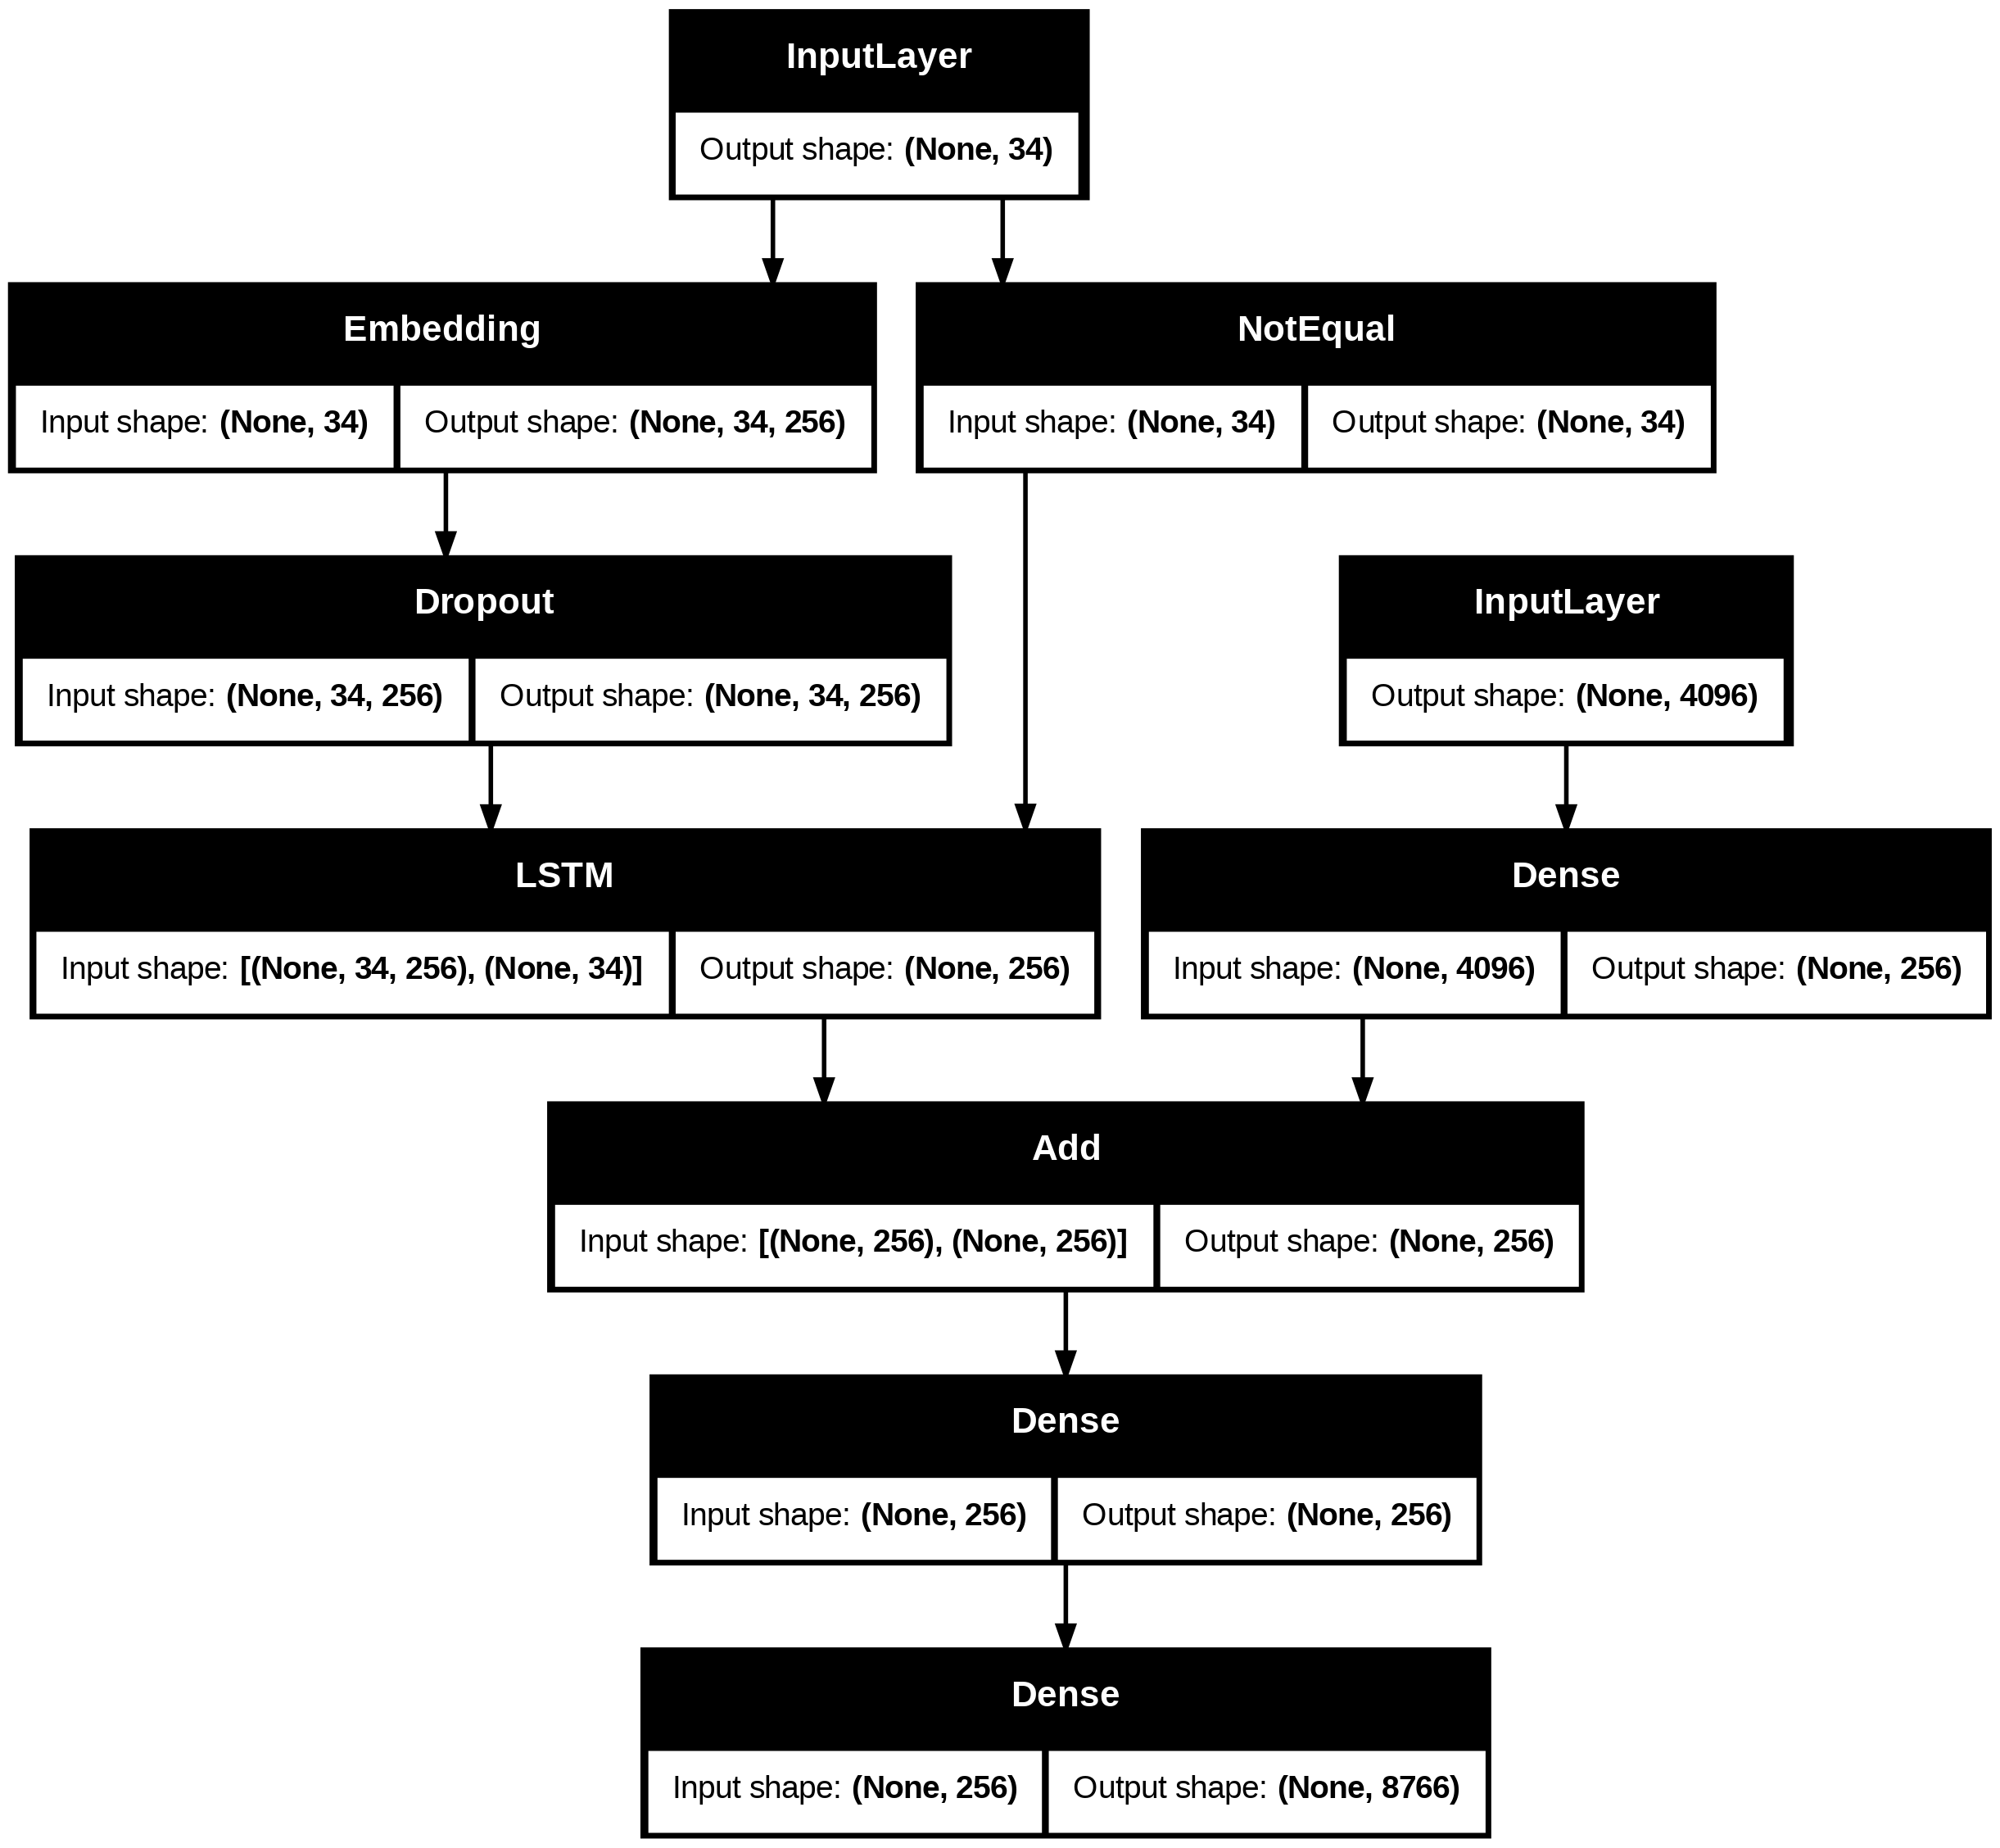

In [141]:
# plot the model
plot_model(model, show_shapes = True)

In [177]:
# Create the dataset once
batch_size = 32
steps = len(train) // batch_size*2
epochs = 10
train_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(train, mapping, features, tokenizer, max_len, vocab_size, batch_size),
    output_signature=(
        (
            tf.TensorSpec(shape=(None, 4096), dtype=tf.float32),      
            tf.TensorSpec(shape=(None, max_len), dtype=tf.int32)      
        ),
        tf.TensorSpec(shape=(None, vocab_size), dtype=tf.float32)     
    )
)

model.fit(train_dataset, epochs=epochs, steps_per_epoch=steps, verbose=1)

Epoch 1/10
454/454 ━━━━━━━━━━━━━━━━━━━━ 96s 208ms/step - loss: 5.2615
Epoch 2/10
454/454 ━━━━━━━━━━━━━━━━━━━━ 95s 209ms/step - loss: 3.4721
Epoch 3/10
454/454 ━━━━━━━━━━━━━━━━━━━━ 94s 207ms/step - loss: 3.0185
Epoch 4/10
454/454 ━━━━━━━━━━━━━━━━━━━━ 94s 207ms/step - loss: 2.7648
Epoch 5/10
454/454 ━━━━━━━━━━━━━━━━━━━━ 94s 207ms/step - loss: 2.5894
Epoch 6/10
454/454 ━━━━━━━━━━━━━━━━━━━━ 94s 208ms/step - loss: 2.4538
Epoch 7/10
454/454 ━━━━━━━━━━━━━━━━━━━━ 94s 207ms/step - loss: 2.3442
Epoch 8/10
454/454 ━━━━━━━━━━━━━━━━━━━━ 94s 208ms/step - loss: 2.2522
Epoch 9/10
454/454 ━━━━━━━━━━━━━━━━━━━━ 94s 208ms/step - loss: 2.1736
Epoch 10/10
454/454 ━━━━━━━━━━━━━━━━━━━━ 94s 208ms/step - loss: 2.1078


In [178]:
model.save(Working_dir + '/best_model.h5')

# Generate caption for the image

In [179]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [180]:
# Generate caption for the image

def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'start'
    #iterate over the max length of the sequence
    for i in range(max_len):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad sequences
        sequence = pad_sequences([sequence], max_len, padding = 'post')
        # predict next word
        y_hat = model.predict([image, sequence], verbose = 0)
        # get index with high probability
        y_hat = np.argmax(y_hat)
        # convert index to word
        word = idx_to_word(y_hat, tokenizer)
        # stop if word not found 
        if word is None:
            break
        # break word as inputp for generating next word
        in_text += " " + word
        #stop if we reach end tag
        if word == 'end':
            break
    return in_text
        

In [181]:
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    #get acutal caption
    captions = mapping[key]
    #predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_len)
    actual_captions = [caption.split() for caption in captions]
    
    # split into words
    y_pred = y_pred.split()
    actual.append(actual_captions)
    predicted.append(y_pred)


# calculate BLEU score

print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights = (1.0, 0, 0 ,0)))
print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights = (0.5, 0.5, 0 ,0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.540238
BLEU-2: 0.324685


# visualize the results

In [227]:
def generate_captions(*image_names):
    plt.figure(figsize=(9, 9))  

    for idx, image_name in enumerate(image_names):
        image_id = image_name.split('.')[0]
        img_path = os.path.join(Base_dir, 'Images', image_name)
        image = Image.open(img_path)

        # Get actual captions
        actual_captions = mapping[image_id]
        actual_text = "\n".join([cap.replace("start", "").replace("end", "").strip() for cap in actual_captions])

        # Predict caption
        predicted_caption = predict_caption(model, features[image_id], tokenizer, max_len)
        predicted_text = predicted_caption.replace("start", "").replace("end", "").strip()

        # Display image
        plt.subplot(2, 2, idx + 1)
        plt.imshow(image)
        plt.axis('off')
        plt.title(f"Actual:\n{actual_text}\n\nPredicted:\n{predicted_text}", fontsize=8)

    plt.tight_layout()
    plt.show()


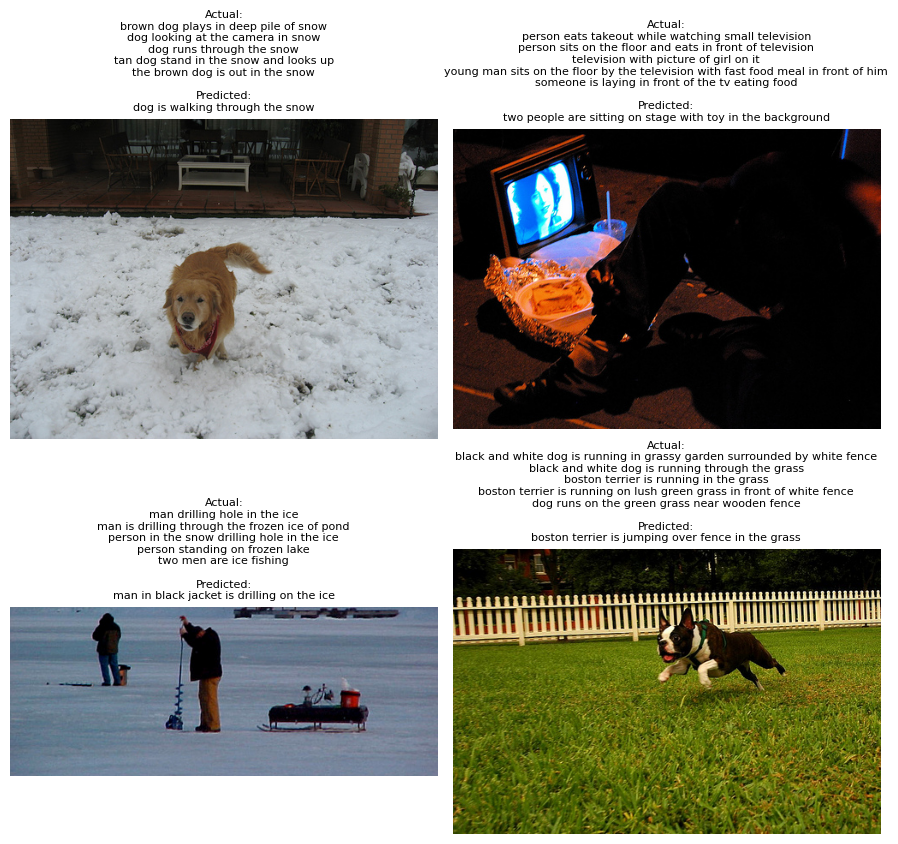

In [228]:
generate_captions('1094462889_f9966dafa6.jpg','1045521051_108ebc19be.jpg','102351840_323e3de834.jpg','1009434119_febe49276a.jpg')